# Deep and Reinforcement Learning 2024/2025 (M.IA003), FEUP/FCUP

## Deep Learning Project 
## **Develop deep learning discriminative and generative models, applied to the context of “deep fakes”**

work done by:
- Michal Kowalski up
- Pedro Pereira up
- Pedro Azevedo up201905966

## 1.1) Import Necessary

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
import matplotlib.pyplot as plt
import os
import tensorflow as tf
import glob
from _model import *
from tensorflow.keras.models import load_model
import json


print(tf.config.list_physical_devices('GPU'))
# tf.keras.mixed_precision.set_global_policy('mixed_float16')

2025-03-25 19:18:03.394929: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1742930283.414956   19873 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742930283.421708   19873 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1742930283.439546   19873 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1742930283.439583   19873 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1742930283.439587   19873 computation_placer.cc:177] computation placer alr

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
# Define dataset directories
data_dir = "data"
real_dir = os.path.join(data_dir, "real")
fake_dir = os.path.join(data_dir, "fake")

## 1.2) Basic EDA

In [ ]:
from _eda import base_stats

base_stats(real_dir, fake_dir)

## 1.3) File Standardization 

In [ ]:
from _preprocess import standardize_files

standardize_files('data/real', (64, 64), '64')
standardize_files('data/fake', (64, 64), '64')

In [ ]:
real_dir = os.path.join(data_dir, "real_normalized_64")
fake_dir = os.path.join(data_dir, "fake_normalized_64")
base_stats(real_dir, fake_dir)

## 1.4) Baseline

In [2]:
gan = build_gan(d_lr=1e-5, label_smoothing=True)

/home/jscrambler/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-03-25 19:18:08.145069: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
I0000 00:00:1742930288.146520   19873 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4148 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6
/home/jscrambler/.local/lib/python3.10/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


In [4]:
gan.summary()

Model: "gan"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 64, 64, 3)      │     1,110,752 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,110,752 (4.24 MB)

 Trainable params: 1,094,176 (4.17 MB)

 Non-trainable params: 16,576 (64.75 KB)

In [3]:

batch_size = 256
# Get all image file paths

def save_paths(path_list, fname):
    with open(fname, "w") as final:
	    json.dump(path_list, final)

# Define the preprocessing function
def load_and_preprocess(image_path):
    # Read the image file
    image = tf.io.read_file(image_path)

    # Decode the JPEG image
    image = tf.image.decode_jpeg(image, channels=3)

    # Normalize the image to the range [-1, 1]
    image = (tf.cast(image, tf.float32) / 127.5) - 1.0

    return image

def load_paths(train_file, test_file):
    with open(train_file, "r") as train:
	    train_paths = json.load(train)
    with open(test_file, "r") as test:
	    test_paths = json.load(test)
    return train_paths, test_paths

# image_paths = glob.glob("./data/real_normalized_64/*.jpg")
# train_paths = image_paths[:25000]
# test_paths = image_paths[25000:]
# save_paths(train_paths, 'train.json')
# save_paths(test_paths, 'test.json')

train_paths, test_paths = load_paths('./train.json', './test.json')

# Create the dataset
dataset = tf.data.Dataset.from_tensor_slices(train_paths)
dataset = dataset.map(load_and_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
dataset = dataset.shuffle(buffer_size=1000).batch(batch_size//2, drop_remainder=True).prefetch(tf.data.AUTOTUNE)

In [ ]:
gan.discriminator.summary()

Epoch 0, D Loss: 1.4857186079025269, G Loss: 0.8971291780471802


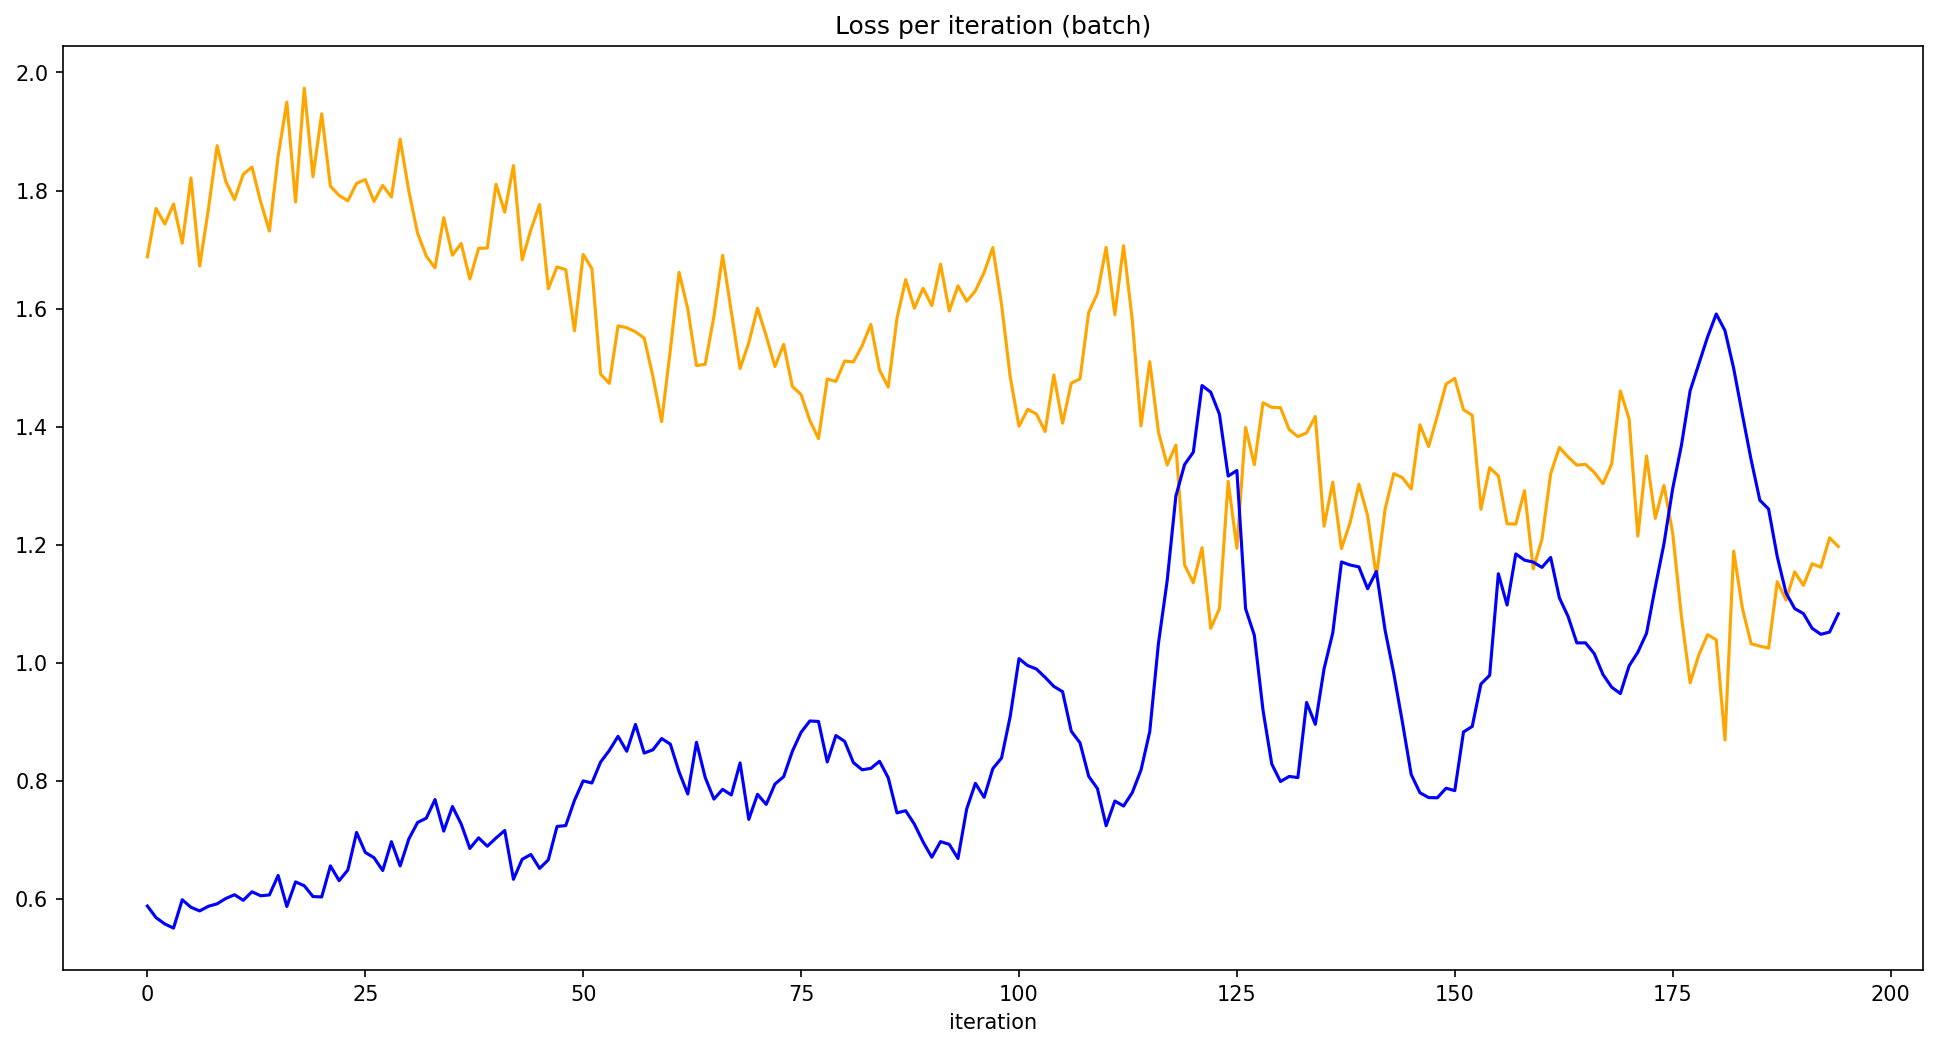

I0000 00:00:1742930340.096784   20018 service.cc:152] XLA service 0x780eac0056b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1742930340.096823   20018 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
2025-03-25 19:19:00.106640: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 772ms/step


I0000 00:00:1742930340.731653   20018 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


In [4]:
d_losses, e_losses = train_gan(gan, dataset, epochs=1, batch_size=batch_size)

In [5]:
gan.save('ls_dlr.keras')

/home/jscrambler/.local/lib/python3.10/site-packages/keras/src/saving/saving_api.py:107: UserWarning: You are saving a model that has not yet been built. It might not contain any weights yet. Consider building the model first by calling it on some data.
  return saving_lib.save_model(model, filepath)


In [6]:
final_d_losses = [float(x) for x in d_losses]
final_g_losses = [float(x) for x in e_losses]
with open('d_losses.json', "w") as f:
    json.dump(final_d_losses, f)

with open('g_losses.json', "w") as f:
    json.dump(final_g_losses, f)

# 1.5) Load Model

In [6]:
gan = keras.models.load_model("ls_dlr.keras", custom_objects={"GAN": GAN})

/home/jscrambler/.local/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 24 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/home/jscrambler/.local/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [7]:
gan.summary()

Model: "gan"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 64, 64, 3)      │     1,110,752 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (128, 1, 1, 1)         │     2,767,360 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,878,112 (14.79 MB)

 Trainable params: 3,859,744 (14.72 MB)

 Non-trainable params: 18,368 (71.75 KB)

In [ ]:
d_losses, e_losses = train_gan(dataset, d, g, do, go, epochs=200, batch_size=batch_size)